8
(214, 3)


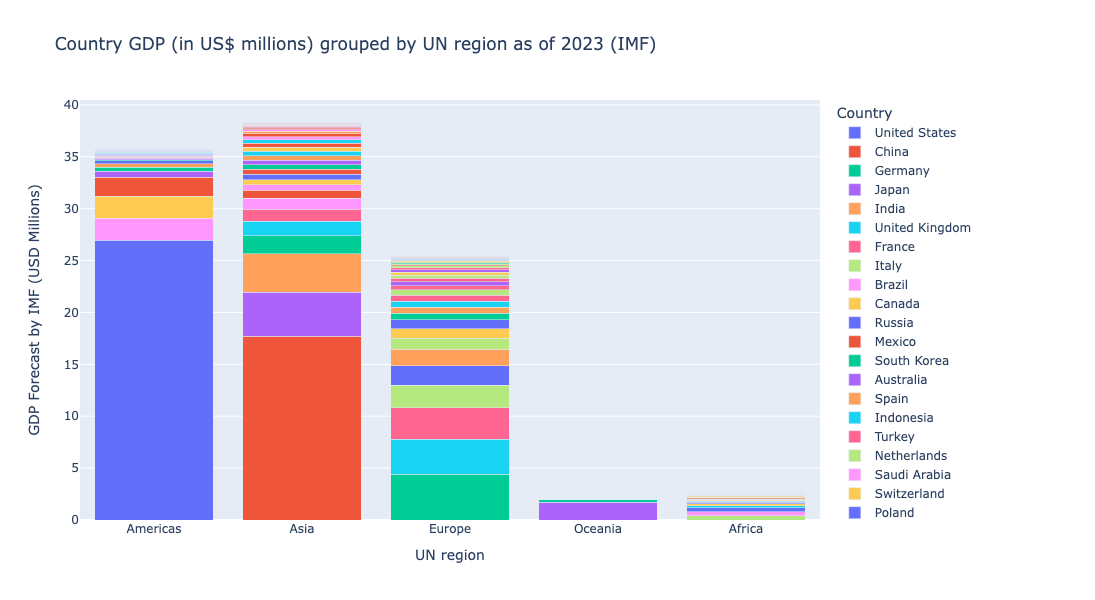

In [13]:
import requests as rq
import bs4
import pandas as pd

url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
page = rq.get(url)
## print out the first 200 characters just to see what it looks like
page.text[0 : 99]

bs4page = bs4.BeautifulSoup(page.text, 'html.parser')
tables = bs4page.find_all('table',{'class':"wikitable"})

from io import StringIO
# Read the table from the StringIO object into pandas
# Note most recent version of pandas won't accept a string as input, it needs to be passed through stringio
countryGDP = pd.read_html(StringIO(str(tables[0])))[0]
countryGDP = countryGDP.dropna()
countryGDP.head()

# Check the number of columns in the DataFrame
print(countryGDP.shape[1])  # This will print the number of columns

# Drop the last four columns if there are more than four columns
if countryGDP.shape[1] > 4:
    countryGDP = countryGDP.iloc[:, :-5]


print(countryGDP.shape)
countryGDP.head()

import plotly.express as px


# Extract relevant columns and clean the data
countryGDP = countryGDP[['Country/Territory', 'UN region', 'IMF[1][13]']]
countryGDP.columns = ['Country', 'UN region', 'IMF']
countryGDP = countryGDP.dropna()

countryGDP['IMF'] = pd.to_numeric(countryGDP['IMF'], errors='coerce')

# Drop rows with NaN values in the 'IMF' column
countryGDP = countryGDP.dropna(subset=['IMF'])
countryGDP = countryGDP.iloc[1:]


# Convert GDP values to millions (USD)
countryGDP['IMF'] = countryGDP['IMF'] / 1000000

# Create the bar plot
fig = px.bar(countryGDP, x='UN region', y='IMF', color='Country', 
             title='Country GDP (in US$ millions) grouped by UN region as of 2023 (IMF)',
             labels={'IMF': 'GDP Forecast by IMF (USD Millions)', 'Country': 'Country'},
             barmode='stack')

# Update layout to adjust size and other properties
fig.update_layout(width=1000, height=600, yaxis_title='GDP Forecast by IMF (USD Millions)')

# Show the plot
fig.show()

fig.write_html("stacked_bar.html")


In [43]:
import pandas as pd
import plotly.express as px
import numpy as np

## load in the hierarchy information
url = "https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt"
multilevel_lookup = pd.read_csv(url, sep = "\t").drop(['Level5'], axis = 1)
multilevel_lookup = multilevel_lookup.rename(columns = {
    "modify"   : "roi", 
    "modify.1" : "level4",
    "modify.2" : "level3", 
    "modify.3" : "level2",
    "modify.4" : "level1"})
multilevel_lookup = multilevel_lookup[['roi', 'level4', 'level3', 'level2', 'level1']]
multilevel_lookup.head()

## Now load in the subject data
id = 127
subjectData = pd.read_csv("https://raw.githubusercontent.com/smart-stats/ds4bio_book/main/book/assetts/kirby21AllLevels.csv")
subjectData = subjectData.loc[(subjectData.type == 1) & (subjectData.level == 5) & (subjectData.id == id)]
subjectData = subjectData[['roi', 'volume']]
## Merge the subject data with the multilevel data
subjectData = pd.merge(subjectData, multilevel_lookup, on = "roi")
subjectData = subjectData.assign(icv = "ICV")
subjectData = subjectData.assign(comp = subjectData.volume / np.sum(subjectData.volume))
subjectData.head()




,roi,volume,level4,level3,level2,level1,icv,comp
0,SFG_L,12926,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.009350
1,SFG_R,10050,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,ICV,0.007270
2,SFG_PFC_L,12783,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.009247
3,SFG_PFC_R,11507,SFG_R,Frontal_R,CerebralCortex_R,Telencephalon_R,ICV,0.008324
4,SFG_pole_L,3078,SFG_L,Frontal_L,CerebralCortex_L,Telencephalon_L,ICV,0.002227


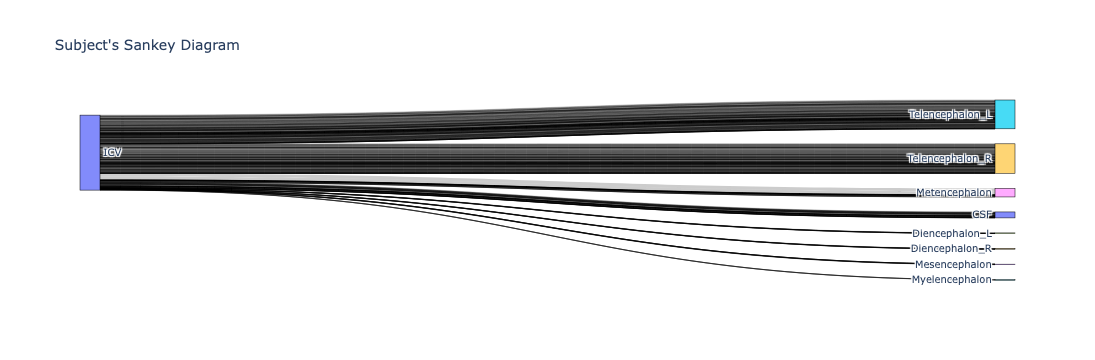

In [18]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load in the hierarchy information
url = "https://raw.githubusercontent.com/bcaffo/MRIcloudT1volumetrics/master/inst/extdata/multilevel_lookup_table.txt"
multilevel_lookup = pd.read_csv(url, sep="\t")
multilevel_lookup = multilevel_lookup.rename(columns={
    "modify": "roi", 
    "modify.1": "level4",
    "modify.2": "level3", 
    "modify.3": "level2",
    "modify.4": "level1"
})
multilevel_lookup = multilevel_lookup[['roi', 'level4', 'level3', 'level2', 'level1']]

id = 127
subjectData = pd.read_csv("https://raw.githubusercontent.com/smart-stats/ds4bio_book/main/book/assetts/kirby21AllLevels.csv")
subjectData = subjectData.loc[(subjectData.type == 1) & (subjectData.level == 5) & (subjectData.id == id)]
subjectData = subjectData[['roi', 'volume']]
## Merge the subject data with the multilevel data
subjectData = pd.merge(subjectData, multilevel_lookup, on = "roi")
subjectData = subjectData.assign(icv = "ICV")
subjectData = subjectData.assign(comp = subjectData.volume / np.sum(subjectData.volume))
subjectData.head()

# Create nodes
nodes = ['ICV', 'level1', 'level2', 'level3', 'level4']
nodes += subjectData[['level1', 'level2', 'level3', 'level4']].stack().unique().tolist()

# Create links
links = []
icv_index = nodes.index('ICV')
for index, row in subjectData.iterrows():
    links.append({
        'source': icv_index,
        'target': nodes.index(row['level1']),
        'value': row['volume']
    })

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links]
    )
))

fig.update_layout(title_text="Subject's Sankey Diagram", font_size=10)
fig.show()